# Course URLs

In this notebook do the following:

    1) Identify the highest scoring pages, for each base URL, from the Markov Crawler
    2) Identify common features of URLs with high scores
    3) Use PCA to identify combinations of URL features that lead to high scores
    4) Identify compound phrases from text on the pages of these URLs
    5) TODO: Cluster words to find topics
    6) Plan next step

In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

from sqlalchemy import create_engine
import pandas as pd
from urllib.parse import urlparse
from collections import Counter
import re
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from nltk.stem import WordNetLemmatizer
import numpy as np
import requests
from bs4 import BeautifulSoup
from graph_scorer import GraphScorer
from matplotlib import pyplot as plt
from compounder import Compounder

from fuzzywuzzy import process as fuzzy_process
from fuzzywuzzy import fuzz
import wikipedia
from collections import Counter

from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans
import gensim

//anaconda/envs/py35/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [3]:
lemmatizer = WordNetLemmatizer()
_stops = set(stopwords.words("english"))

'''
Split words by tokens, including numbers as tokens. Useful for splitting URLs.
'''
def tokenize_alphanum(text):
    words = list(filter(('').__ne__, re.split('[^a-zA-Z]',text)))
    _words = []
    for w in words:
        w = w.lower()
        w = lemmatizer.lemmatize(w)
        _words.append(w)
    return _words

'''
Split words according to a Viterbi Segmentation algorithm.
E.g. degreecourse -> degree course
Needs to be trained by a relevant corpus. Note: don't include words in the
corpus that you don't want to be found!
'''
class WordSplitter:
    '''Define the word corpus'''
    def __init__(self,words):
        self.corpus = Counter(words)
        self.max_word_length = max(map(len,self.corpus))
        self.total = float(sum(self.corpus.values()))

    '''Get the fraction of vocab corresponding to this word'''
    def word_prob(self,word):
        # A small workaround for plurals, could be extended to fuzzy matching
        if word not in self.corpus:
            if word[:-1] in self.corpus:
                word = word[:-1]
        return self.corpus[word] / self.total
    '''Split word according to Viterbi algorithm'''
    def split(self,text):
        probs, lasts = [1.0], [0]
        for i in range(1, len(text) + 1):
            prob_k, k = max((probs[j] * self.word_prob(text[j:i]), j)
                            for j in range(max(0, i - self.max_word_length), i))
            probs.append(prob_k)
            lasts.append(k)
        words = []
        i = len(text)
        while 0 < i:
            words.append(text[lasts[i]:i])
            i = lasts[i]
        words.reverse()
        score = probs[-1]
        # If score is zero, return the original string
        if score == 0.:
            return [text],0
        return words,score


## Identify the highest scoring pages, for each base URL, from the Markov Crawler

Here I print out the top 5 highest scoring pages for each base URL. The results are ok, although a bit mixed as one might expect.

In [4]:
# Connect to database where data is found
with open("db.config") as f:
    engine_url = f.read()
engine = create_engine(engine_url)
conn = engine.connect()

# Load data into dataframes
df_pages = pd.read_sql_table("page_scores",con=conn)
df_tops = pd.read_sql_table("top_urls",con=conn)

# Assign a base URL to each page, by iterating through
# each base URL
df_pages["top_url"] = None
for _,url in df_tops.url.items():
    # Normalise the page to the score of the base URL, so extract
    # the base URL's score
    condition = df_pages.page == url
    topurl_score = df_pages.loc[condition,"score"].values[0]

    # Split the top URL, since only expect to find the netloc in a given page
    # e.g. www.manchester.ac.uk and www.research.manchester.ac.uk
    _parsed = urlparse(url)
    _joined = _parsed.scheme +"://" + _parsed.netloc
    condition = df_pages.page.str.contains(_parsed.netloc.replace("www.",""))
    # Assign a normalised score, and the base URL
    df_pages.loc[condition,"norm_score"] = df_pages.loc[condition,"score"]/topurl_score
    df_pages.loc[condition,"top_url"] = _joined
    
    # Print out "top 5" results
    _df = df_pages.loc[condition].sort_values("norm_score",ascending=False).head(5)
    print(_joined)
    for _,row in _df.iterrows():
        print(row["page"].replace(_joined,""),row["norm_score"])        
    print("-------------------")

http://www.manchester.ac.uk
/study/postgraduate-research/programmes/research-areas 1.4651873148963208
https://www.research.manchester.ac.uk/portal/en/publications/search.html 1.23936874236101
/study/undergraduate/courses/2018 1.2114514661583506
/study/postgraduate-research/contact 1.2099949126173424
/study/undergraduate/courses/2017 1.1546036591158086
-------------------
https://www.masdar.ac.ae
/visitor 1.4048698227547218
/research-education/partners-and-resources 1.346091716725332
/research-education/innovation-centers/iwater 1.3005225309011408
/research-education/degree-offerings 1.2972706155017852
/aboutus/useful-info/printed-material 1.2590632576989362
-------------------
http://www.birmingham.ac.uk
/university/colleges/artslaw/staff.aspx 2.129924767088331
/libraries/index.aspx 2.128522411821165
/schools/engineering/index.aspx 2.0381854442420098
/libraries/subject/index.aspx 2.03070238457869
/research/activity/clinical-sciences/index.aspx 1.8902829424172236
-------------------
htt

IndexError: index 0 is out of bounds for axis 0 with size 0

## Identify common features of URLs with high scores

In order to generate more meaningful results, I opt to analyse common features of URLs with high scores in order to filter out spurious results.

First I plot the distribution of scores, which is useful if only to show the distribution is at least approximately symmetric. I originally attempted to sample more uniformally across the distribution, but it turns out that this isn't really necessary. The first step, however, is to exclude very bad pages by requiring non-zero scores.

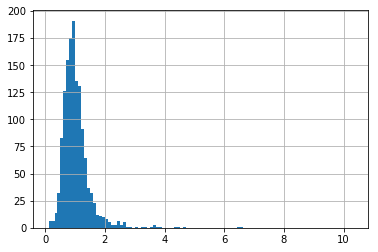

In [5]:
# Only use non-zero scores
df_pages = df_pages.loc[df_pages.score > 0]

# Plot the log of the scores
log_scores = df_pages["norm_score"]
bins = np.arange(min(log_scores),max(log_scores),0.1)
log_scores.hist(bins=bins)

# freqs,lims = np.histogram(log_scores,bins)
# def get_freq(value):
#     if np.fabs(value) > 4:
#         return 0
#     for i,x in enumerate(lims):
#         if value <= x:
#             if freqs[i-1] == 0:
#                 return 0
#             return 1/freqs[i-1]**3
#     return 0
# df_pages["weights"] = log_scores.apply(get_freq)

### URL contents

Before analysing URL contents, it is necessary to remove any common "junk" associated with university URLs. I additionally include "html" and "aspx" as these don't provide any predictive power. I therefore compile a list of stop words, in the context of academic URLs, and also include the standard NLTK stop words.

I then make a count of the common non-stop terms found in URLs.

In [6]:
# Generate a list of stops from base URLs
stop_urls = ["html","aspx"]
for url in df_tops.url.values:
    stop_urls += tokenize_alphanum(url)
stop_urls = set(stop_urls).union(_stops)

# Count common non-stops
common_words = []
for url in df_pages.page.values:
    for w in tokenize_alphanum(url):
        if not w in stop_urls:
            common_words.append(w)
c = Counter(common_words)

One caveat with the above procedure is that I will miss URLs with wordscompoundedtogether. Therefore, I train a word splitter (see near top of notebook for WordSplitter) with the 200 most common words found. Therefore 'hiddden' words like "degreecourse" should be found as "degree" "course".

In [7]:
# Train a word splitter with the most common words,
# but first reweight each word by it's occurence
_common_words = []
for w,s in c.most_common(200):
    # This way earch word, w, will appear s times
    _common_words += [w]*s
wsplitter = WordSplitter(_common_words)
_common_words = set(_common_words)

In [8]:
# Try to find any hidden words
common_words = []
for url in df_pages.page.values:
    # Split the URL into words
    for w in tokenize_alphanum(url):
        # If not a stop word
        if w in stop_urls:
            continue
        # Get the split word
        split_word,score = wsplitter.split(w)
        # If the word can't be split
        if score == 0 or len(split_word) == 1:
            common_words.append(w)
        # Otherwise append the components
        else:
            for s in split_word:
                common_words.append(s)

# Recount the words, ignore short words (en,u etc)
c = Counter(common_words)
common_words = [w for w,_ in c.most_common(200) if len(w) > 2]

Finally, the contents of each page's URL can be formalised by creating a binary variable for each common word.

In [9]:
# Create a binary variable for each common word
for w in common_words:
    # Generate one bool per URL in df_pages
    condition = []    
    for url in df_pages.page.values:
        # Check whether the tokens contain the common word
        url_tokens = tokenize_alphanum(url)

        # Firstly, is the word in the URL?
        found_word = w in url_tokens
        # Otherwise, check whether any tokens can be split to
        # find the common word
        if not found_word:
            for token in url_tokens:
                split_word,score = wsplitter.split(token)
                if score > 0 and len(split_word) > 1:
                    found_word = w in split_word
        # Append this flag
        condition.append(found_word)
    # Append this word's condition (Note: I use an underscore to avoid column conflicts)
    df_pages["_"+w] = condition

### Distribution of URL terms

Now I look at the distribution of URL terms. Firstly I indentify words that are definitely unimportant or detrimental to a high score by considering whether the mean score of URLs containing each word are *significantly* higher than the mean score. Note significance is defined in terms of standard deviations.


Note: this is where I previously mentioned that I could sample a uniform distribution with weights

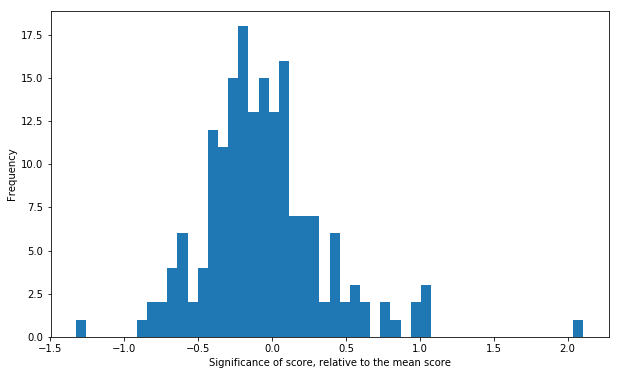

In [10]:
_df = df_pages #.sample(n=1000,weights="weights")

# Columns not related to words
drop_cols = ["page","score","norm_score","top_url"]

# Decide which of the words are actually important by comparing their effect on the mean 
d = {}
mean = _df["norm_score"].mean()
std = _df["norm_score"].std()
for col in _df.drop(drop_cols,axis=1).columns:
    _mean = _df.loc[_df[col],"norm_score"].mean()
    _std = _df[col].std()
    d[col] = (_mean - mean)/np.sqrt(std*std + _std*_std)

# Plot the results
fig,ax = plt.subplots(figsize=(10,6))
_ = ax.hist(list(d.values()),bins=50)
ax.set_ylabel("Frequency")
ax.set_xlabel("Significance of score, relative to the mean score")

The above is enough to motivate me into cutting words with a significance of 0.1

In [11]:
# Only keep the most significant words
for w,s in Counter(d).most_common():
    if s < 0.1:
        _df.drop(w,axis=1,inplace=True)
len(_df.columns)

54

### Combinations of URL terms

Now I perform PCA on the words identified above, fitted with respect to the normalised score.

In [12]:
pca = PCA()
_pca = pca.fit(y=_df["norm_score"],X=_df.drop(drop_cols,axis=1))

It is found that the first 9ish components describe 50% of the variance, which at first seems pretty bad. However, I believe this is obscured by the fact that the distribution of `norm_score` is very noisy. The principal N components therefore could identify combinations of key words that rise above this noise, and are good indicators of pages containing courses. For example, the highest PC explains nearly 10% of variance, which is actually pretty huge.

In [13]:
total = 0
for i,x in enumerate(_pca.explained_variance_ratio_):
    total += x
    #print(total)
    if total > 0.5:
        print(i)
        break
print(_pca.explained_variance_ratio_)

9
[ 0.11017301  0.08518736  0.05252114  0.04905744  0.0438438   0.04217498
  0.04085477  0.03841977  0.02997759  0.02884661  0.02691523  0.02663878
  0.02624788  0.02587565  0.02304958  0.02204769  0.02124936  0.02049994
  0.01617408  0.01585362  0.01523768  0.01481933  0.01455394  0.01421435
  0.01370439  0.0132476   0.01230321  0.0120076   0.01010983  0.00870186
  0.0086139   0.00847353  0.00827081  0.00771417  0.00760734  0.00746846
  0.00739634  0.00720747  0.0070589   0.00675965  0.0062417   0.00618848
  0.00611109  0.00597404  0.00564725  0.00543089  0.00521255  0.0035512
  0.00327683  0.00128733]


To motivate this further, look at the four most common words in each PC describing more than 5% of the variance (below). They look really very sensible.

In [14]:
for i,(comp,var) in enumerate(zip(_pca.components_,_pca.explained_variance_ratio_)):
    if var < 0.05:
        break
    d = {w:c for w,c in zip(_df.drop(drop_cols,axis=1).columns,comp)}
    print(i,var)
    for w,c in Counter(d).most_common(5):
        print("\t",w,c)
    print("")

0 0.110173010725
	 _program 0.789462543071
	 _undergraduate 0.543052020129
	 _graduate 0.114352417181
	 _requirement 0.108690108532
	 _postgraduate 0.0637612399296

1 0.0851873574167
	 _college 0.957047466055
	 _program 0.154267280266
	 _graduate 0.122755340674
	 _science 0.0957872707366
	 _art 0.0763989750428

2 0.0525211355292
	 _program 0.444767430156
	 _degree 0.244966274832
	 _graduate 0.230994775341
	 _engineering 0.170119680704
	 _postgraduate 0.136421248974



Therefore, I use the first 3 PCs to rank URLs in order to extract course information from. I take the top 5 (`DataFrame.head`) URLs, ranked according to these 3 PCs, and take the set of these (therefore a maximum of 15 URLs per base URL)

In [15]:
urls_to_try = {}

for i in range(0,3):
    # Calculate the i'th PC
    pc = "pca"+str(i)
    _cols = drop_cols
    _df[pc] = [x[i] for x in _pca.transform(_df.drop(_cols,axis=1))]
    # Get the top values of the i'th PC per top_url
    for top_url,grouped in _df.groupby("top_url"):
        # If not already added this top_url to the list
        if top_url not in urls_to_try:
            urls_to_try[top_url] = set()
        for v in grouped.sort_values(pc,ascending=False).head()["page"].values:
            urls_to_try[top_url].add(v)
    # Make sure this new column is dropped in future iterations of this forloop
    if pc not in drop_cols:
        _cols.append(pc)

urls_to_try["https://www.masdar.ac.ae"].add("https://www.masdar.ac.ae/research-education/degree-programs/undergraduate-programs")
urls_to_try["https://www.masdar.ac.ae"].add("https://www.masdar.ac.ae/research-education/degree-programs/doctorate-programs")
urls_to_try["https://www.masdar.ac.ae"].add("https://www.masdar.ac.ae/research-education/degree-programs/master-s-programs")
urls_to_try["http://www.kustar.ac.ae"].add("http://www.kustar.ac.ae/pages/undergraduate-programs")
urls_to_try["http://www.zu.ac.ae"].add("https://www.zu.ac.ae/main//en/admission/undergraduate-programs/programs.aspx")
urls_to_try["https://www.aus.edu"].add("https://www.aus.edu/info/200135/undergraduate_programs")
urls_to_try["https://www.aus.edu"].add("https://www.aus.edu/info/200136/graduate_programs")
urls_to_try["https://aau.ac.ae"].add("https://aau.ac.ae/en/academics/undergraduate-programs/")
urls_to_try["https://aau.ac.ae"].add("https://aau.ac.ae/en/academics/graduate-programs/")
urls_to_try["https://www.ajman.ac.ae"].add("https://www.ajman.ac.ae/en/admission-and-registration/undergraduate/programs-offered.html")
urls_to_try["https://www.ajman.ac.ae"].add("https://www.ajman.ac.ae/en/admission-and-registration/graduate-admissions/graduate-programs-offered.html")
urls_to_try["http://nyuad.nyu.edu"].add("http://nyuad.nyu.edu/en/academics/undergraduate-programs/majors.html")
urls_to_try["http://www.kustar.ac.ae"].add("http://www.kustar.ac.ae/pages/undergraduate-admissions")
urls_to_try["http://www.kustar.ac.ae"].add("http://www.kustar.ac.ae/pages/graduate-admissions")

The URLs I find are given below (Note: these aren't ordered by preference):

In [16]:
for top_url,urls in urls_to_try.items():
    print(top_url,len(urls))
    for url in urls:
        print("\t",url)
    print()

https://www.sheffield.ac.uk 12
	 https://www.sheffield.ac.uk/postgraduate/taught/courses/arts/biblical/religion-leadership-society-ma
	 https://www.sheffield.ac.uk/postgraduate/taught
	 https://www.sheffield.ac.uk/undergraduate/finance
	 https://www.sheffield.ac.uk/postgraduate/accommodation
	 http://www.sheffield.ac.uk/undergraduate/finance/fees/2017
	 https://www.sheffield.ac.uk/undergraduate/finance/fees-calculator
	 https://www.sheffield.ac.uk/postgraduate/taught/apply
	 https://www.sheffield.ac.uk/postgraduate/taught/courses/arts-humanities
	 https://www.sheffield.ac.uk/postgraduate/taught/courses/pure-science
	 https://www.sheffield.ac.uk/news/nr/best-universities-arts-humanities-rankings-world-1.730131
	 https://www.sheffield.ac.uk/undergraduate/why/facilities
	 https://www.sheffield.ac.uk/postgraduate/taught/distance-learning

http://www.sharjah.ac.ae 14
	 http://www.sharjah.ac.ae/en/academics/degree-program/Pages/default.aspx
	 http://www.sharjah.ac.ae/en/about/contact_us/Page

## Topic modelling of courses
    1) Iterate through course pages
    2) Record sections of text with high graph score
    3) Create n-grams according to previous method
    4) Count the most frequent n-grams (after stop word removal)
    5) Select courses from the sentences containing the most frequent n-grams

In [17]:
from bs4.element import Comment

def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

def len_sentence(x):
    try:
        return len(tokenize_alphanum(x))
    except TypeError as err:
        print("Error with",x)
        raise err      

def get_sentences(url,return_url=False):
    r = requests.get(url)
    if r.status_code != 200:
        print(url,"not found")
        return []
    soup = BeautifulSoup(r.text,"lxml")
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)
    if not return_url:        
        return [t.strip() for t in visible_texts 
                if len_sentence(t) > 0]
    
    # Otherwise, find corresponding URL
    sentences = []
    anchors = [a for a in soup.findAll("a")
               if tag_visible(a) and
               len_sentence(a.text) > 0]
    anchor_text = [a.text for a in anchors]
    for t in visible_texts:
        if len_sentence(t) == 0:
            continue
        _url = None
        if t in anchor_text:
            a = list(filter(lambda a : t==a.text,anchors))[0]
            if "href" in a.attrs:
                _url = a.attrs["href"]  
        sentences.append(dict(go_to_url=_url,text=t,found_on_url=url))
    return sentences

In [18]:
# Loop over URLs, collect all sentences
sentences = []
for top_url,urls in urls_to_try.items():
    for url in urls:
        sentences += get_sentences(url)
#         print(url)
#         print(get_sentences(url,True))
        break
    break
print("Got",len(sentences),"sentences")

Got 184 sentences


In [19]:
def superlog(x):
    if x <= 0:
        return 0
    return np.log10(x)

# fig,ax = plt.subplots(figsize=(10,6))
# weights,bins,patches = ax.hist(list(map(len_sentence,sentences)),bins=np.arange(0,250,1))
# max_height = 0
# for p in patches:
#     new_height = superlog(p.get_height())
#     p.set_height(new_height)
#     max_height = max((max_height,new_height))
    
# ax.set_ylim(0,1.1*max_height)
# ax.set_ylabel("log$_{10}$(count)")
# ax.set_xlabel("sentence length")

In [ ]:
# # Only use short sentences
# _sentences = [s for s in sentences if len_sentence(s) < 20]

# # Perform N-gram extraction
# comper = Compounder(max_context=3,threshold=7)
# comper.process_sentences(_sentences)
# comper.print_sorted_compounds()

In [ ]:
# # Iterate with the previous chunk to set the threshold
# comp_data = pd.DataFrame(comper.data)
# fig,ax = plt.subplots(figsize=(10,10))
# for context,grouped in comp_data.groupby("context"):
#     ax.plot(grouped["threshold"],grouped["total"].apply(superlog),label=context)
# ax.legend()

## Different approach: get sentences with high similarity to any UCAS word

In [20]:
r = requests.get("http://search.ucas.com/subject/fulllist")
ucas = []
soup = BeautifulSoup(r.text,"lxml")
for a in soup.find_all("a"):
    if "href" not in a.attrs:
        continue
    if not a.attrs["href"].startswith("/subject/"):
        continue
    words = [w for w in tokenize_alphanum(a.text)
             if w not in _stops]
    ucas.append(" ".join(words))

In [21]:
def get_wiki_quals(url,tokenize=True):
    r = requests.get(url)
    soup = BeautifulSoup(r.text,"lxml")
    ucas = []
    for a in soup.find_all("a"):
        if "href" not in a.attrs:
            continue
        href = a.attrs["href"]
        if not href.startswith("/wiki/"):
            continue
        text_elements = a.text.split()
        if len(text_elements) < 1:
            continue
        if text_elements[0].lower() not in href.lower():
            continue
        if tokenize:
            words = [w for w in tokenize_alphanum(a.text)
                     if w not in _stops]
        else:
            words = a.text.split()
        ucas.append(" ".join(words))
    return set(ucas)

ucas_1 = get_wiki_quals("https://en.wikipedia.org/wiki/Category:Bachelor%27s_degrees")
ucas_2 = get_wiki_quals("https://en.wikipedia.org/wiki/List_of_master%27s_degrees")
ucas_3 = get_wiki_quals("https://en.wikipedia.org/wiki/Category:Doctoral_degrees")
ucas += list(ucas_1.symmetric_difference(ucas_2).symmetric_difference(ucas_3))

In [22]:
# Get all UCAS words
all_ucas = ["msc","ba","master","bachelor","phd"]
for u in ucas:
    all_ucas += tokenize_alphanum(u)
all_ucas = set(all_ucas)
print(all_ucas)

{'talk', 'bachelor', 'danish', 'eundem', 'event', 'rabbinic', 'science', 'academy', 'yoga', 'chemistry', 'liberal', 'diplom', 'project', 'country', 'therapy', 'cyber', 'medicine', 'candidate', 'architecture', 'national', 'laurea', 'doctoral', 'sacred', 'chain', 'contribution', 'related', 'ba', 'medicinae', 'social', 'multiplex', 'aquatic', 'child', 'civil', 'naturopathy', 'diploma', 'information', 'student', 'doctorate', 'habilitation', 'honour', 'theology', 'music', 'diplomacy', 'nickname', 'academic', 'professional', 'system', 'dance', 'independent', 'source', 'affair', 'portal', 'forensic', 'humanity', 'law', 'estate', 'economy', 'applied', 'accountancy', 'assurance', 'research', 'msc', 'study', 'lacking', 'teaching', 'specialist', 'sarajevo', 'ad', 'agriculture', 'biomedical', 'divinity', 'isced', 'thesis', 'european', 'physician', 'dottorato', 'modern', 'service', 'library', 'humane', 'phd', 'engineering', 'enterprise', 'policy', 'pharmacy', 'design', 'random', 'kinetics', 'doktor

In [23]:
class MatchScore(dict):
    def match_score(self,sentence):
        scores = []
        for w in tokenize_alphanum(sentence):
            if w not in self:                
                match,_score = fuzzy_process.extractOne(w,all_ucas)
                length_ratio = len(match)/len(w)
                # Normalise to length ratio
                if length_ratio > 1:
                    length_ratio = 1/length_ratio
                self[w] = (_score/100)*(length_ratio**2)   
            scores.append(self[w])            
        # Score = sqrt( (sum_i score_i^2) / sum_i )
        if len(scores) == 0:
            return 0
        score = np.sqrt(sum(map(lambda x:x**2,scores)) / len(scores))
        return score

matchScore = MatchScore()

In [29]:
def level_checker(query,levels=["bachelor","master","phd","diploma","doctor"]):
    # Check if the qualification type is in the query
    for lvl in levels:
        if lvl in query:
            return lvl 
    return None
        
def get_qual_type(query):
    _q = tokenize_alphanum(query)
    lvl = level_checker(_q)
    if lvl is not None:
        return lvl

    # Otherwise, search for the acronym
    for word in _q:
        for qual,acronyms in qual_map.items():
            if word in acronyms:
                return level_checker(qual)
    return None

In [30]:
matchScore.match_score("B.Sc. in Aerospace Engineering")
get_qual_type("B.Sc. in Aerospace Engineering")

In [31]:
def clean_text(t):
    # Replace bad chars
    bad_chars = ["\n","\r"]
    for c in bad_chars:
        t = t.replace(c,"")
    # Strip space
    while "  " in t:
        t = t.replace("  "," ")
    t = t.lstrip()
    t = t.rstrip()
    words = t.split()
    # Remove long words
    if len(words) > 11:
        return None
    # Standardise qualifications
    for w in t.split():
        if w in qual_map:
            t = t.replace(w,min(qual_map[w], key=len))
    if "program" in q.lower():
        return None
    return t

url_courses = {}
for top_url,urls in urls_to_try.items():
#     if "ajman" not in top_url:
#          continue
    print(top_url)
    url_courses[top_url] = []
    for url in set(urls):
#         if "undergraduate/programs-offered" not in url:
#             continue
#         print("\t",url)
        for data in get_sentences(url,return_url=True):
            #print(data["text"])
            data["text"] = clean_text(data["text"])
            if data["text"] is None:
                continue
            score = matchScore.match_score(data["text"]) #fuzzy_process.extractOne(s,ucas,scorer=fuzz.token_sort_ratio)
            if score > 0.6:
                if data not in url_courses[top_url]:
                    url_courses[top_url].append(data)
            #print("\t\t",data["text"],score)
    #print(url_courses[top_url])
    #print()

https://www.sheffield.ac.uk
http://www.sharjah.ac.ae
http://www.manchester.ac.uk
https://aau.ac.ae
https://www.ajman.ac.ae
https://www.masdar.ac.ae
http://www.birmingham.ac.uk
http://www.pi.ac.ae
http://www.uowdubai.ac.ae
http://www.buid.ac.ae
https://www.aus.edu
https://gmu.ac.ae
http://www.kustar.ac.ae
https://www.adu.ac.ae
http://nyuad.nyu.edu
http://www.zu.ac.ae


In [27]:
def tidy(x,except_=""):
    return re.sub(r'[^a-zA-Z0-9'+except_+']','',x)

def gen_guess(name,n):
    guess = []
    for i,w in enumerate(name.split()):
        if w in _stops:
            continue
        if i == 0:
            guess.append(w[0])
        else:
            guess.append(w[0:n])
    guess = ".".join(guess)
    return guess

def find_qualification(name):
    p = wikipedia.page(name)
    words = {}

    for i in [1,2]:
        guess = gen_guess(name,i)
        if len(guess) == 0:
            continue
        _guess = tidy(guess)

        for word in p.summary.split():
            _word = tidy(word)
            if _word in _stops:
                continue
            if len(_word) == 0:
                continue
            if _word[0] != _guess[0]:
                continue
            #
            score = fuzz.ratio(_guess,_word)        
            norm = len(_guess)/len(_word)
            if norm > 1:
                norm = 1/norm

            _w = tidy(word,except_=".")
            if score*norm > 0:
                if _w in words:
                    if words[_w] > score*norm:
                        continue
                words[_w] = score*norm    
    #
    output = []
    for qual,score in Counter(words).most_common():
        if score > 50:
            output.append(qual)
    return output

wiki_1 = get_wiki_quals("https://en.wikipedia.org/wiki/Category:Bachelor%27s_degrees",False)
wiki_2 = get_wiki_quals("https://en.wikipedia.org/wiki/List_of_master%27s_degrees",False)
wiki_3 = get_wiki_quals("https://en.wikipedia.org/wiki/Category:Doctoral_degrees",False)
wiki = list(wiki_1.symmetric_difference(wiki_2).symmetric_difference(wiki_3))

In [28]:
qual_map = {}
for w in wiki:
    if not any(w.startswith(x) for x in ("Ma","Ba","Dip","Doc","PhD")):
        continue
    if w.strip() == "":
        continue
    quals = find_qualification(w)
    print(w)
    print("\t",quals)
    for q in quals:
        if q not in qual_map:
            qual_map[q] = set()
        qual_map[q].add(w)

Master of Professional Studies
	 ['M.P.S.', 'MPS']
Bachelor of Applied Arts
	 ['BAA', 'B.A.A.']
Bachelor of Economics
	 ['BEc']
Master of Science in Health Informatics
	 []
Bachelor of Business
	 ['BBus']
Magister degree
	 []
Bachelor of Library Science
	 ['BLS', 'B.L.S.', 'B.L.I.S.', 'BLIS.', 'BLib', 'B.Lib.']
Master of Business Informatics
	 ['MBI']
Master of Medicine
	 ['MMed']
Bachelor of Computer Science
	 ['BCS', 'BSE', 'B.Sc.', 'BSc', 'BSCS', 'BCompSc', 'BASc', 'BS']
Doctor of Science
	 ['D.Sc.', 'D.S.', 'Dr.Sc.']
Doctor of Nursing Practice
	 ['DNP', 'DNAP.']
Master of Science in Engineering
	 ['MSE', 'MScEng', 'M.Sc.Eng.']
Master of Industrial and Labor Relations
	 []
Doctor of Civil Law
	 ['D.C.L.', 'DCL']
Master of Computational Finance
	 []
Master of Pharmacy
	 []
Master of Real Estate Development
	 []
Bachelor of Human Kinetics
	 ['BHKin', 'BHk', 'BScHK']
Master of Business Administration
	 ['MBA', 'M.B.A.']
Bachelor of Music
	 ['B.M.']
Doctor of Project Management
	 ['DPM'

PageError: Page id "master of public services" does not match any pages. Try another id!

In [32]:
    output = []
    for top_url,data in url_courses.items():
        if ".ac.uk" in top_url:
            continue
        for row in data:
            qual = get_qual_type(row["text"])
            if qual is None and row["go_to_url"] is not None:
                qual = get_qual_type(row["go_to_url"])
            if qual is not None:
                if not row["text"].lower().startswith(qual):
                    qual = None
                else:
                    row["qualification"] = qual      
            row["home_url"] = top_url
            output.append(row)

In [37]:
output[2900]

{'found_on_url': 'http://www.kustar.ac.ae/pages/undergraduate-programs',
 'go_to_url': None,
 'home_url': 'http://www.kustar.ac.ae',
 'text': 'Humanities and Social Sciences (12 credits):'}

In [ ]:
with open("courses-tier0.json","w") as f:    
    f.write(str(output))

In [ ]:
from ast import literal_eval
with open("courses-tier0.json") as f:
    js = literal_eval(f.read())
    df = pd.DataFrame(js)
df.tail()

In [ ]:
qual_lens = []
for home,grouped in df.groupby("home_url"):
    qs = set(grouped.loc[grouped.qualification=="doctor","text"].values)
    print(home,len(qs))
    for q in qs:
        qual_lens.append(len(q.split()))
        if len(q.split()) > 11:
            continue
        #if not q.lower().startswith("master"):
        #    continue
        if "program" in q.lower():
            continue
        print("\t",q)
    print()
        
print(min(qual_lens),
      np.percentile(qual_lens,10),
      np.percentile(qual_lens,50),
      np.percentile(qual_lens,90),
      max(qual_lens))

## Now analyse basic features
    a) What qualifications are on offer? (count by unique text-home-qual)
    b) Can qualification be mapped into key topics from wikipedia?
         Engineering
         Maths
         Chemistry
         Physics
         Biology
         Computing
         Other

In [ ]:
def filter_stops(t):
    return " ".join(filter(lambda x : x not in _stops,t.split()))

def unique_text(texts,fuzzy_req=0.95):
    unique_vals = []
    for t in texts:
        _t = filter_stops(t)
        found_match = False
        for v in unique_vals:
            _v = filter_stops(v)
            score_1 = fuzz.ratio(t,v)/100
            score_2 = fuzz.token_sort_ratio(t,v)/100
            score = np.sqrt((score_1**2 + score_2**2)/2)
            if score >= fuzzy_req:
                found_match = True
                #if score < 0.98:
                    #print(t,"too similar to",v,score)
                break
        if not found_match:
            unique_vals.append(t)
    return unique_vals

unique_text(["joel klinger","joel klinger","joel a klinger"])

In [ ]:
valid_values = []

unique_quals = set(df.qualification.values)
qual_table = []
for home,grouped in df.groupby("home_url"):
    print(home)
    
    condition = grouped.text.apply(lambda x : (x not in ["Bachelors Degree","Bachelor Degree:",
                                                        "Bachelor of Arts","Bachelor of Science 302",
                                                        "Bachelors Degree","Diploma",
                                                        "Bachelor’s Programs","Master’s Programs",
                                                        "Master’s thesis (6 credit hours)",
                                                        "Masters Degree",
                                                        'PhD','PhD Alumni Testimonials',
                                                        'PhD BM Programme Structure'])
                                                        and len(x.split()) < 11)
                                                        
    grouped = grouped.loc[condition]
    
    _grouped = grouped.loc[~pd.isnull(grouped.qualification)]
    allowed_values = unique_text(_grouped.text)
    valid_values += allowed_values
    grouped = grouped.loc[grouped.text.apply(lambda t:t in allowed_values)]
    too_long = grouped.text.apply(lambda t: len(t.split()) > 11) # 11 = 90%ile
    grouped = grouped.loc[~too_long]
    grouped.drop_duplicates("text",inplace=True)
    
    _data = dict(home=home)
    for _qual in unique_quals:
        if pd.isnull(_qual):
            condition = pd.isnull(grouped.qualification)
        else:
            condition = grouped.qualification == _qual            
        _data[_qual] = (condition).sum()
    _data["not_null"] = (~pd.isnull(grouped.qualification)).sum()
    qual_table.append(_data)
qual_table = pd.DataFrame(qual_table)#,columns=["home","bachelor","master","phd","nan"])
qual_table["phd"] = qual_table["phd"] + qual_table["doctor"]
qual_table = qual_table[["home","bachelor","master","phd",np.nan,"not_null","doctor","diploma"]]
qual_table = qual_table.sort_values("not_null",ascending=False)
qual_table = qual_table.drop(["not_null","doctor",np.nan,"diploma"],axis=1)
qual_table.columns = ["Home","Bachelor","Master","Doctoral"] #,"Other (including bad results)"]
qual_table

In [ ]:
condition = df.text.apply(lambda x: x in valid_values)
_df = df.loc[condition].drop_duplicates("text")
print(len(_df))

n = 0
for _,grouped in _df.groupby("home_url"):
    n += len(grouped.drop_duplicates("text"))
print(n)
sorted(list(_df["text"].values))

In [ ]:
def get_cats(t):
    s = wikipedia.search(t)
    if len(s) < 1:
        return []
    s = s[0]
    try:
        p = wikipedia.page(s)
        return [c for c in p.categories
                if len(c.split()) <= 3]
    except (wikipedia.DisambiguationError,wikipedia.PageError):
        return []

def subject(query,by):
    for result in reversed(query.partition(" "+by+" ")):
        if result != '':
            return result.lstrip(" ")
    
results = {}
i = 0
for _,row in _df.iterrows():
    i += 1
    q = row.qualification
    _t = re.sub(r'\([^)]*\)', '',  row.text)
    if _t in results:
        continue
    
    # First get categories for the qualification
    t = _t
    if (not pd.isnull(q)) and (q.lower() not in t.lower()):
        t = _t+" "+q
    cats = get_cats(t)
    
    # Then attempt to get categories for the subject
    for by in ["of","in"]:
        t = subject(_t,by)
        if t == _t:
            continue
        cats += get_cats(t)

    results[_t] = cats
    
print(i,(~pd.isnull(df.qualification)).sum())
for k,v in results.items():
    print(k)
    print(v)
    print()

In [ ]:
# Collect categories on random pages to filter out common junk categories
random_cats = []
for s in wikipedia.random(pages=100):
    try:
        p = wikipedia.page(s)
    except (wikipedia.DisambiguationError,wikipedia.PageError):
        continue
    random_cats += p.categories
    
random_words = []
for cat in random_cats:
    random_words += [w for w in tokenize_alphanum(cat)]

count_rcats = [c for c,_ in Counter(random_cats).most_common(20)]
words_rcats = [w for w,_ in Counter(random_words).most_common(20)]

In [ ]:
# The collect the categories together, ommitting junk cats and words
cats = []
words = []
for _,r in results.items():
    cats += [c for c in r if c not in count_rcats]
    for cat in r:
        words += [w for w in tokenize_alphanum(cat)
                  if w not in words_rcats and len(w) > 1]

cats_count = Counter(cats)
words_count = Counter(words)

In [ ]:
cats_count.most_common()

In [ ]:
words_count.most_common()

In [ ]:
# Assign a list of keywords to each row of data
# Calculate total fraction of ug/pg
# Then, by subject, calculate fractions of ug/pg
# Then d3 bars of subjects (on hover change fraction, but static) (top) and fractions (non-clickable, but dynamic) (bottom)

In [ ]:
from matplotlib.patches import Rectangle

_df.loc[_df.qualification == 'doctor','qualification'] = 'phd'
fig,ax = plt.subplots(figsize=(10,1))

color = ['skyblue','darkslategrey','coral']

x0 = 0
for qual,c in zip(['bachelor','master','phd'],color):        
    n = (_df.qualification == qual).sum()
    
    if qual == 'phd':
        qual = 'Doctoral'    
    rect = Rectangle((x0,0),x0+n,1,facecolor=c,label=qual.title())
    ax.add_patch(rect)
    x0 += n
    
ax.axis('off')
ax.set_ylim(0,1)
ax.set_xlim(0,x0)
leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
def cat_plot(qual_type):
    
    fig,ax = plt.subplots(figsize=(10,1))

    color = ['skyblue','darkslategrey','forestgreen','orange','y','coral','gray']
    labels = ['Comp/IT','Engineering','Medical','Education','Business','Science','Other']
    
    x0 = 0
    _kw = []
    for kw,c,L in zip([('comp',' it ','info','network','software'),
                     ('eng',),
                     ('health','medic','nursing','pharma'),('education','teaching'),
                     ('business','manag','admin','financ','commerce'),('science',),                     
                     ('',)],color,labels):
        condition = _df.qualification == qual_type
        condition = _df.loc[condition,"text"].apply(lambda x : 
                                                    any(k in x.lower() for k in kw)
                                                    and not any(k in x.lower() for k in _kw))
        n = condition.sum()
        if kw == ('',):
            kw = "Other"
        
        
        rect = Rectangle((x0,0),x0+n,1,facecolor=c,label=L)
        ax.add_patch(rect)
        x0 += n
        _kw += list(kw)

    ax.axis('off')
    ax.set_ylim(0,1)
    ax.set_xlim(0,x0)
    
    if qual_type == 'phd':
        qual_type = 'Doctoral'
    
    leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),title=qual_type.title())
    
cat_plot('bachelor')
cat_plot('master')
cat_plot('phd')